# Bank Marketing Data Set Group Project Proposal
> Alex Khadra, Shay Tannne, Liam Buchan, Tanaya Parakh

## Introduction:
The data set we are working on is the bank marketing data set. The bank we are analyzing is a Portuguese banking institution with data related with direct marketing campaigns (phone calls). 

A term deposit is a cash investment, where your money is invested for an agreed rate of interest over a fixed amount of time, or term.

Our data set includes:
- `age` - Age
- `job` - Type of job
- `marital` - Marital status
- `education` - Level of education
- `default` - Has credit in default?
- `balance` - Account balance (EUR)
- `housing` - Has housing loan?
- `loan` - Has personal loan?
- `contact` - Contact communication type
- `month` - Last contact month of year
- `day_of_week` - Last contact day of the week
- `duration` - Last contact duration, in seconds
- `campaign` - Number of contacts performed during this campaign and for this client
- `pdays` - Number of days that passed by after the client was last contacted from a previous campaign
- `previous` - Number of contacts performed before this campaign and for this client 
- `poutcome` - Outcome of the previous marketing campaign
- `y` - Has the client subscribed a term deposit?

Throughout the project we will look at all the variables and see how they relate to clients subscribing to a term deposit. We will than find which variables have the greatest influence on predicting whether or not a client will subscribe a term deposit.


## Wrangling and Preliminary Analysis
To be able to access the functions used throughout this project, we must first load these libraries:

In [19]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)

In [20]:
bank_all_cols <- read_delim("data/bank-full.csv", delim = ';')
bank_all_cols

Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no


In [17]:
# Please refer to "Methods" section to see why we preformed the select function
bank_all <- bank_all_cols %>%
    select(-c(default, contact, duration))
bank_all

age,job,marital,education,balance,housing,loan,day,month,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,2143,yes,no,5,may,1,-1,0,unknown,no
44,technician,single,secondary,29,yes,no,5,may,1,-1,0,unknown,no
33,entrepreneur,married,secondary,2,yes,yes,5,may,1,-1,0,unknown,no
47,blue-collar,married,unknown,1506,yes,no,5,may,1,-1,0,unknown,no
33,unknown,single,unknown,1,no,no,5,may,1,-1,0,unknown,no
35,management,married,tertiary,231,yes,no,5,may,1,-1,0,unknown,no
28,management,single,tertiary,447,yes,yes,5,may,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,2,yes,no,5,may,1,-1,0,unknown,no
58,retired,married,primary,121,yes,no,5,may,1,-1,0,unknown,no


In [24]:
bank_split <- initial_split(bank_all, prop = 0.75, strata = y)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

In [25]:
# To summarize the data in a table we use the summary function 
print("Summary Table:")
summary(bank_train)

[1] "Summary Table"


      age            job              marital           education        
 Min.   :18.00   Length:33909       Length:33909       Length:33909      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :39.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40.98                                                           
 3rd Qu.:48.00                                                           
 Max.   :95.00                                                           
    balance         housing              loan                day       
 Min.   : -8019   Length:33909       Length:33909       Min.   : 1.00  
 1st Qu.:    71   Class :character   Class :character   1st Qu.: 8.00  
 Median :   449   Mode  :character   Mode  :character   Median :16.00  
 Mean   :  1371                                         Mean   :15.81  
 3rd Qu.:  1432                                         3rd Qu.:21.00  
 Max.   :102127                                   

Throughout our project, we will be comparing different variables to see if the client subscribed a term deposit. But before we do that, we will compare the other variables with each other. For example, if we use balance and education to determine whether or not a client subscribes, we will first compare education and balance. If education and balance are positively related they should both be related to the client subscribing in the same way. If they are negatively related the should relate to the client subscribed in opposite ways. In our graph we will take a look at the relationship between balance and education. 

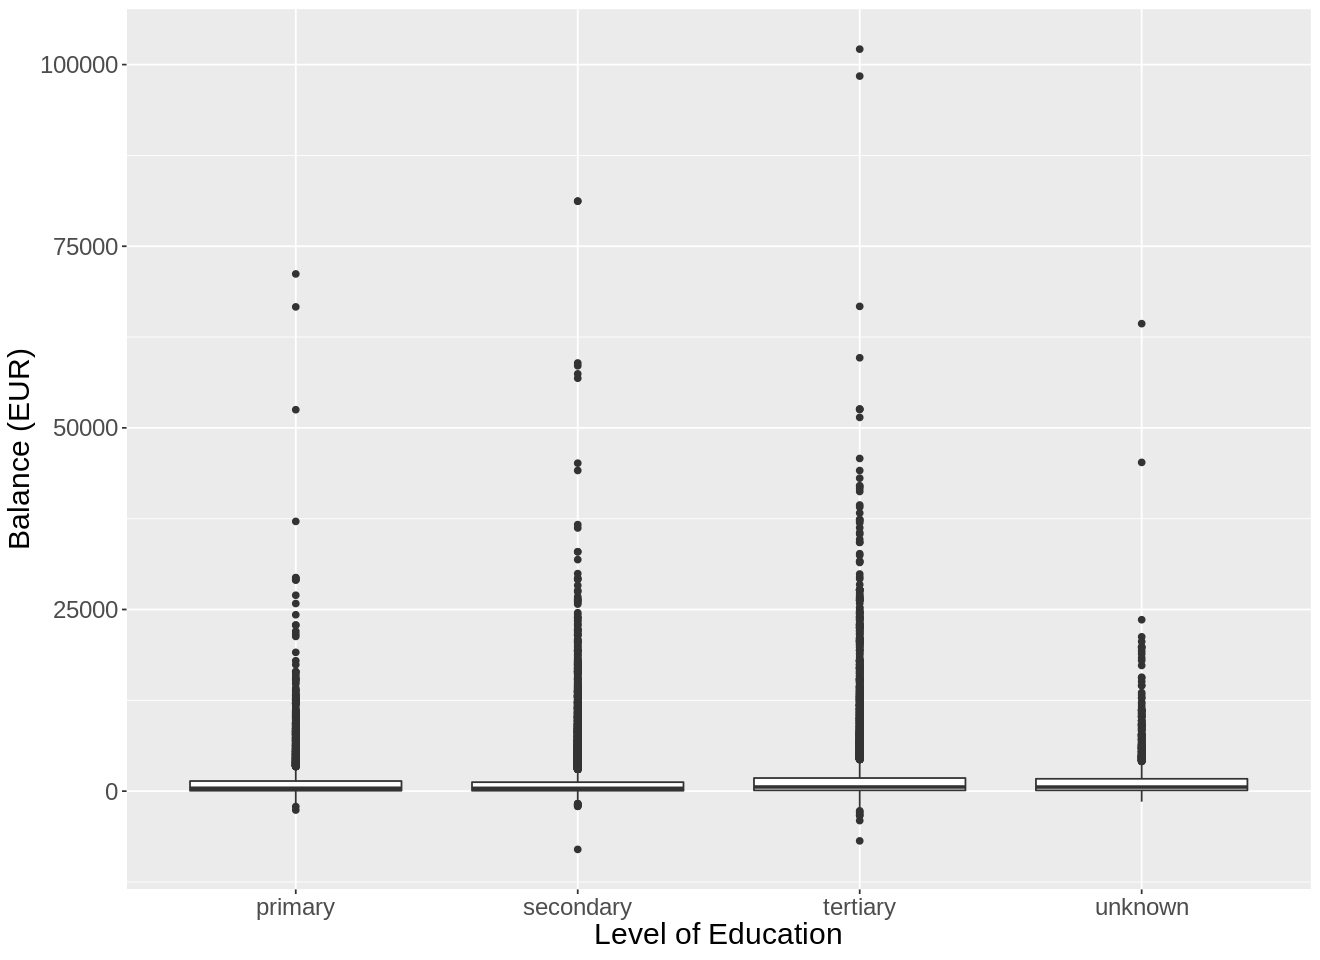

In [15]:
options(repr.plot.width=11, repr.plot.height=8)
balance_vs_education <- ggplot(bank_all, aes(x = education, y = balance)) +
    geom_boxplot() +
    labs(x = "Level of Education", y = "Balance (EUR)") +
    theme(text = element_text(size = 18))
balance_vs_education

From our boxplot, we can see that the balance is similar for all levels of education.

We also see if there is a relationship between age and balance. Since these are two quantitative variables we do not use a boxplot but instead a scatterplot. 

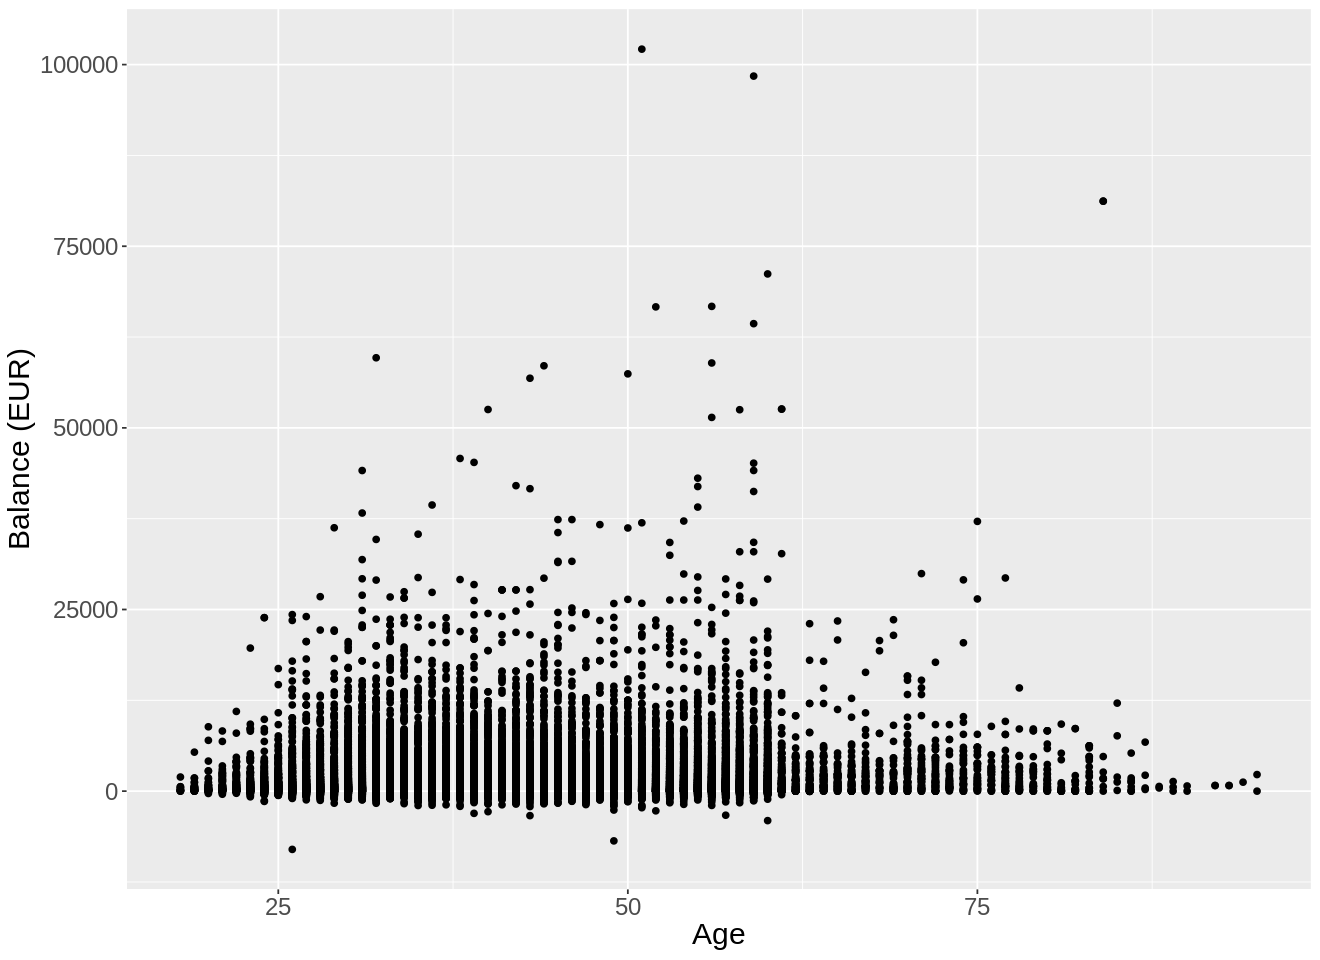

In [21]:
balance_vs_age <- ggplot(bank_all, aes(x = age, y = balance)) +
    geom_point() +
    labs(x = "Age", y = "Balance (EUR)") +
    theme(text = element_text(size = 18))
balance_vs_age

From this graph we see that there may be a relation but that the relationship is not linear.

### Method

When refering to `bank_all` we can see that we filtered out the columns we thought would not play any relationship to whether or not a client subscribed a term deposit. The columns we did not include are default, contact, duration. We will consider all other columns as they may have a relationship with clients subscribing. We will compare all the other columns to clients subscribing. We will figure out the relationship (if any) through various graphs. These graphs depend on whether or not the predictor is a quantitative variable or a qualitative variable. We will than use the $k$ nearest algorithm to predict the cases in our testing data. To come up with the best $k$ value, we will fold our training data. 

### Expected outcomes and significance

From our project we expect to find a few relationships. First, we expect that balance and education both have a positive relationship on whether or not clients subscribe. We also believe that the peak age for subscribing will be around 35-40 years of age and that married couples will tend to subscribe more often than singles. These impacts could change the marketing and advertising of term deposit to show that it does not require a certain amount of money or that you can start at any age. These findings could lead to further questions such as "Do married couples tend to be more financial responsible than singles?" or "At what age do people tend to care about their money the most?" Many further questions can be analyzed after this project.